# Two-level system

Here we simulate a paradigmatic statistical mechanical model.
The system can be simulated by direct sampling from the Gibbs probability distribution and the solution can be compared with the thoretical one.

## Analytical solution of the model

There are N independent particles that can stay in two energy levels: $\mu_i \in \{0, \epsilon\}$. The set of all the energies of the particles defines the **microstate** of the system $\vec{\mu} = \{ \mu_1, \ldots, \mu_N\}$. We denote with $n$ the number of particles in the excited state $\epsilon$:
$$
n (\vec{\mu}) = \sum_{i=0}^{N} \delta (\mu_i - \epsilon)
$$
where $\delta(x) = 1$ for $x=0$ and $0$ otherwise.
The **Hamiltonian** of the system can be written thes as:
$$
H (\vec{\mu}) = \sum_{i=0}^{N} \mu_i = \epsilon \; n (\vec{\mu})
$$
and the **Boltzman probability distribution** of the canonical ensemble as:
$$
p(\vec{\mu}) = \frac{e^{-\beta H (\vec{\mu})}}{Z}, \hspace{1cm} Z = \sum_{\vec{\mu}} e^{-\beta H (\vec{\mu})}
$$
where $\beta = 1/T$ (choosing $k_b = 1$).

To solve this model it is useful to consider the probability of the system with a given $n$, and therefore the same energy $E = \epsilon n$.
Since the probabilities of the microstates corresponding to a specific $n$ are all equal to $e^{\beta n \epsilon} / Z$, this probability can be obtained just by counting all the microstates that have the same $n$, $\Omega(n)$:
\begin{equation}
p(n) = \Omega(n) \frac{e^{-\beta \epsilon n}}{Z} = \binom{N}{n}\frac{e^{-\beta \epsilon n}}{Z}
\end{equation}
This also implies that the partition function reads:
$$
Z = \sum_{n=0}^N \binom{N}{n} e^{-\beta \epsilon n} = \left( 1 + e^{-\beta \epsilon}\right)^N
$$
which is a binomial series, https://en.wikipedia.org/wiki/Binomial_series. By knowing the explicit formula for the partition function, the average energy of the system can be easily obtained:
$$
\langle E \rangle = - \frac{\partial}{\partial \beta} \log{Z} = \frac{N \epsilon}{1 + e^{\beta \epsilon}}
$$

## Exercise

### 1 - Plot the Boltzmann distribution

Write a function that returns the probability distribution depedent on $n$, and plot it as a function of $n$. Explore also how the distribution changes by varying $N$ and $T$.

You can note that, by increasing $N$, most of the states tend to be visited with zero probability, highlighting that only a small fraction of states are really important.
In other words, the distribution is becoming more and more peaked around the average.

If you instead increase the temperature more particles tend to stay in the excited state, while for low temperature you can observe the condensation in the ground state (of minimal energy).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def boltz_p(n, N, temperature, eps):
  e = np.exp(-eps/temperature)
  return binom(N, n) * e**n / (1 + e)**N

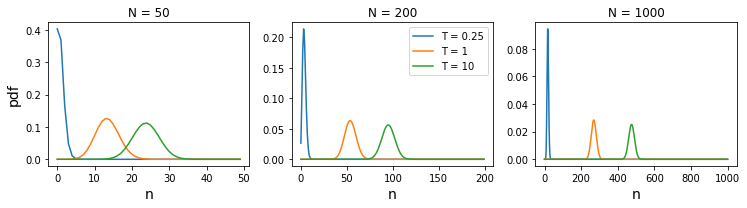

In [2]:
temperatures = [0.25, 1, 10]
Ns = [50, 200, 1000]
eps = 1

fig, axs = plt.subplots(1, len(Ns), figsize=(3.5*len(Ns), 3))

axs[0].set_ylabel('pdf', fontsize=14)

for j in range(len(Ns)):
  ns = np.arange(0,Ns[j])
  axs[j].set_title("N = {}".format(Ns[j]))
  axs[j].set_xlabel('n', fontsize=14)
  for i in range(len(temperatures)):
    axs[j].plot(ns, boltz_p(ns, Ns[j], temperatures[i], eps), label="T = {}".format(temperatures[i]))
axs[1].legend()
plt.tight_layout()

### 2 - Generate samples from the Boltzmann distribution

Generate random samples using the cumulative Boltzmann distribution. Let us call the number of samples $M$. Compare the histogram of the samples with the theoretical distribution at fixed $T$, $\epsilon$, $N$ and for a large $M$, e.g. $M=10000$.

In [3]:
def build_cumulative(temperature, epsilon, N_particles):
  cumulative = [0] 
  ns = np.arange(0, N_particles)
  for n in ns:
    cumulative.append(boltz_p(n, N_particles, temperature, eps) + cumulative[-1])
  return np.array(cumulative)


def generate_sample(N_samples, cumulative):
  samples = []
  for u in np.random.rand(N_samples):
    for i in range(len(cumulative)-1):
      if u < cumulative[i+1]:
        samples.append(i)
        break
  return np.array(samples)

In [4]:
temp = 1
N_part = 50
eps = 1.5
M = 10000

cumulative = build_cumulative(temp, eps, N_part)
samples = generate_sample(M, cumulative)

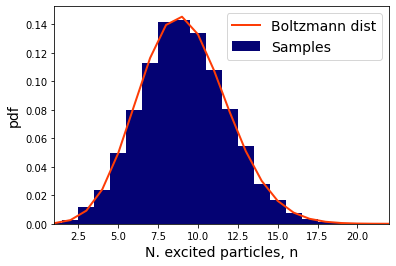

In [5]:
plt.xlabel('N. excited particles, n', fontsize=14)
plt.ylabel('pdf', fontsize=14)

plt.xlim([min(samples), max(samples)])
bins = np.arange(-1,N_part+1)+0.5
plt.hist(samples, bins=bins, density=True, color='#040273', label='Samples')
plt.plot(ns, boltz_p(ns, N_part, temp, eps), color='#fd3c06', label='Boltzmann dist', lw=2)

plt.legend(fontsize=14)

### 3 - Compute the average energy of an ensemble by direct Montecarlo sampling. How the error scales with the number of samples?

3a - By using the sample generator above, write a function that compute the average energy $\langle E \rangle$ (using the sample average), which takes as arguments $T$, $\epsilon$, $N$, and $M$.

In [6]:
def compute_av_energy(temperature, eps, N_particles, N_samples):
  cumulative = build_cumulative(temperature, eps, N_particles)
  samples = generate_sample(N_samples, cumulative)
  return np.mean(samples * eps)

3b - Then study the error that you obtain depending on $M$. In order to do so, consider different number of samples $M_1, M_2, \ldots$.
For each one generate $R=200$ parallel realizations of the internal energy and compute average and stadard deviation.
How the standard deviation scales with $M$?

In [7]:
temp = 1
N_part = 200
eps = 1
n_samples = np.logspace(1,3,20, dtype=int)
n_parallel_trials = 500
average_ene, std_ene = np.empty(0), np.empty(0)

for n in n_samples:
  energies = []
  for _ in range(n_parallel_trials):
    energies.append(compute_av_energy(temp, eps, N_part, n))
  average_ene = np.append(average_ene, np.mean(energies))
  std_ene = np.append(std_ene, np.std(energies))

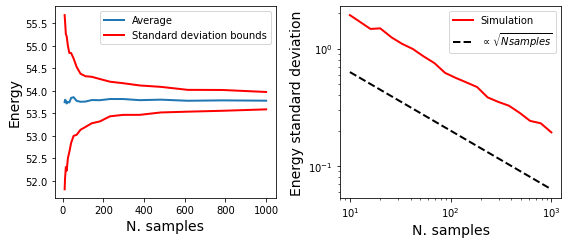

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3.5))

ax1.set_xlabel('N. samples', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.plot(n_samples, average_ene, lw=2, label='Average')
ax1.plot(n_samples, std_ene+average_ene, lw=2, c='r', label='Standard deviation bounds')
ax1.plot(n_samples, -std_ene+average_ene, lw=2, c='r')
ax1.legend()

ax2.set_xlabel('N. samples', fontsize=14)
ax2.set_ylabel('Energy standard deviation', fontsize=14)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.plot(n_samples, std_ene, c='red', lw=2, label='Simulation')
ax2.plot(n_samples, n_samples**(-0.5)*2, c='black', ls='--', lw=2, label=r'$\propto \sqrt{N samples}$')
ax2.legend()

plt.tight_layout()

### 4 - How the average energy scales with the temperature?

Finally, comapare the sampled internal energy with the theroetical formula $\langle E \rangle = N \epsilon /(1 + e^{\beta \epsilon})$. Plot the two functions varying the temperature and fixing $\epsilon$ and $N$.

In [9]:
temperatures = np.linspace(0.01, 10, 100)
N_part = 200
eps = 0.5
N_samples = 200
av_energies = np.empty(0)

for T in temperatures:
  av_energies = np.append(av_energies, compute_av_energy(T, eps, N_part, N_samples))

In [10]:
def th_energy(temp, eps, N_part):
  return eps*N_part / (1 + np.exp( eps/temp ))

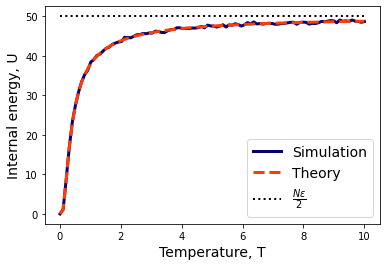

In [11]:
plt.xlabel('Temperature, T', fontsize=14)
plt.ylabel('Internal energy, U', fontsize=14)
plt.plot(temperatures, av_energies, lw=3, color='#040273', label='Simulation')
plt.plot(temperatures, th_energy(temperatures, eps, N_part), lw=3, color='#fd3c06', ls='--', label='Theory')
plt.plot(temperatures, np.ones(len(temperatures))*N_part*eps/2, ls=':', lw=2, c='black', label=r'$\frac{N \epsilon}{2}$')
plt.legend(fontsize=14)

### Extra 5 - Compute the heat capacity of the system

The heat capcity can be obtained by the following formula:
$$
C_v = \frac{\partial E}{\partial T} = \frac{N \epsilon^2 \beta^2 e^{\beta \epsilon}}{(1 + e^{\beta \epsilon})^2}
$$

Here we want to test this formula with the heat capacity computed with samples.
In order to do so you can use the fact that the heat capacity is also related with the width of the energy distribution:
$$
C_v = \beta^2 Var[E]
$$

In [12]:
def compute_heat_C(temperature, eps, N_particles, N_samples):
  cumulative = build_cumulative(temperature, eps, N_particles)
  samples = generate_sample(N_samples, cumulative)
  energies = samples*eps
  return np.var(energies)/temperature**2

In [13]:
temperatures = np.linspace(0.01, 5, 100)
N_part = 200
eps = 2
N_samples = 500

C = np.empty(0)
for T in temperatures:
  C = np.append(C, compute_heat_C(T, eps, N_part, N_samples))

In [14]:
def th_heat_C(temp, eps, N_part):
  return eps*eps*N_part*np.exp( eps/temp ) / (1 + np.exp( eps/temp ))**2 / temp / temp

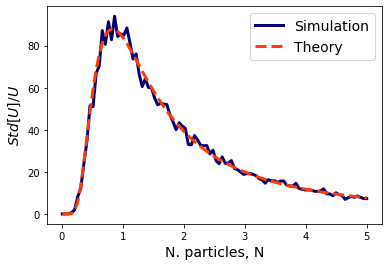

In [15]:
plt.xlabel('N. particles, N', fontsize=14)
plt.ylabel(r"$Std[U] / U$", fontsize=14)
plt.plot(temperatures, C, lw=3, color='#040273', label='Simulation')
plt.plot(temperatures, th_heat_C(temperatures, eps, N_part), lw=3, color='#fd3c06', ls='--', label='Theory')
plt.legend(fontsize=14)